In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, advanced_activations
from keras.optimizers import RMSprop, SGD, Adadelta, Adagrad
from keras import backend as K
from keras.regularizers import WeightRegularizer, l1, l2, activity_l2

import matplotlib
matplotlib.use('PS')
import matplotlib.pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
raw = pd.DataFrame.from_csv('../data/pseudomonas.tsv', sep='\t').transpose()

In [ ]:
y = np.array(raw)
for i in range(raw.shape[0]):
    y[i,:] = y[i,:] / np.sum(y[i,:])
x = preprocessing.scale(y)

In [ ]:
ae = Sequential()
ae.add(Dense(50, input_dim=x.shape[1], W_regularizer=l2(.0000001), activity_regularizer=activity_l2(.000001)))
ae.add(Activation('relu'))
ae.add(Dropout(.1))
ae.add(Dense(x.shape[1], W_regularizer=l1(.000001)))
ae.add(Activation('softmax'))
ae.compile(optimizer=Adagrad(), loss='categorical_crossentropy')
ae.summary()

In [ ]:
history = ae.fit(x, y, batch_size=64, nb_epoch=200, verbose=1, validation_split = 0)
plt.scatter(np.arange(len(np.array(history.history["val_loss"]))), 
            y.shape[0] * (np.array(history.history["val_loss"]) - 8.60414056774551))

In [ ]:
import palettable as pal
cmap=pal.colorbrewer.sequential.BuPu_8.get_mpl_colormap()

get_code = K.function([ae.layers[0].input], [ae.layers[1].output])
code = get_code([x])[0]
df=pd.DataFrame(code)

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)
h=ax.pcolor(df, cmap=cmap)
ax.margins(0,0)
fig.colorbar(h)

In [ ]:
weights = ae.get_weights()[2].flatten()
plt.hist(weights, normed=False, bins=75)
plt.ylabel('counts');

In [ ]:
import palettable as pal
cmap=pal.colorbrewer.diverging.PRGn_11.get_mpl_colormap()

df=pd.DataFrame(ae.get_weights()[2])

fig, ax = plt.subplots(1)
fig.set_size_inches(12,8)
h=ax.pcolor(df, cmap=cmap)
ax.margins(0,0)
fig.colorbar(h)

In [ ]:
outputs = ae.predict(x)
#pd.DataFrame(code).describe()
i = i-10
plt.scatter(special.logit(y[:,i]), special.logit(outputs[:,i]), color = "y")
plt.plot([-9,-8], [-9,-8],color='k', linestyle='-', linewidth=1)

In [11]:
pd.DataFrame(ae.get_weights()[2]).to_csv("ae_weights.csv")

NameError: name 'ae' is not defined

In [ ]:
pd.DataFrame(code).to_csv("ae_codes.csv")

In [19]:
code = pd.DataFrame.from_csv('ae_codes.csv')

GO = pd.DataFrame.from_csv('GO.txt', sep='\t', header=None)
GO_list = list(GO.ix[:,2])
for i in range(len(GO_list)):
    GO_list[i] = GO_list[i].split(";")

In [4]:
KEGG = pd.DataFrame.from_csv('KEGG.txt', sep='\t', header=None)
KEGG_list = list(KEGG.ix[:,2])
for i in range(len(KEGG_list)):
    KEGG_list[i] = KEGG_list[i].split(";")

In [5]:
w = pd.DataFrame.from_csv("ae_weights.csv")
from scipy import stats
hw = list()
for i in range(w.shape[0]):
    q = stats.mstats.mquantiles(w.iloc[i,:], [.025, .975])
    bool = np.array([not (q[0] < x < q[1]) for x in np.array(w.iloc[i,:])])
    hw.append(raw.columns.values[bool])

In [6]:
w.columns=raw.columns
x = abs(w[KEGG_list[4]]).mean(axis = 1) / abs(w).mean(axis = 1)
np.var(np.log(x))

0.1768486631150636

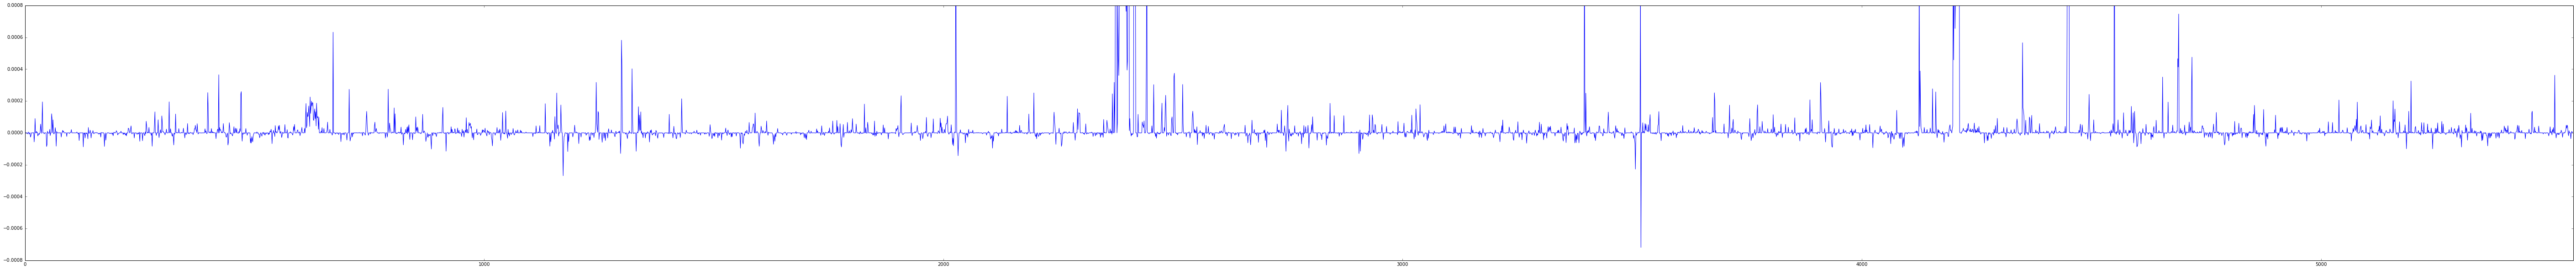

In [7]:
i = 18
from matplotlib.lines import Line2D 
fig, axes = plt.subplots(1)
fig.set_size_inches(100,10)
axes.set_ylim([-.0008,.0008])
axes.set_xlim([0,w.shape[1]])
axes.add_line(Line2D(range(w.shape[1]), np.sign(np.array(w)[i,:]) * (np.array(w)[i,:])**2))

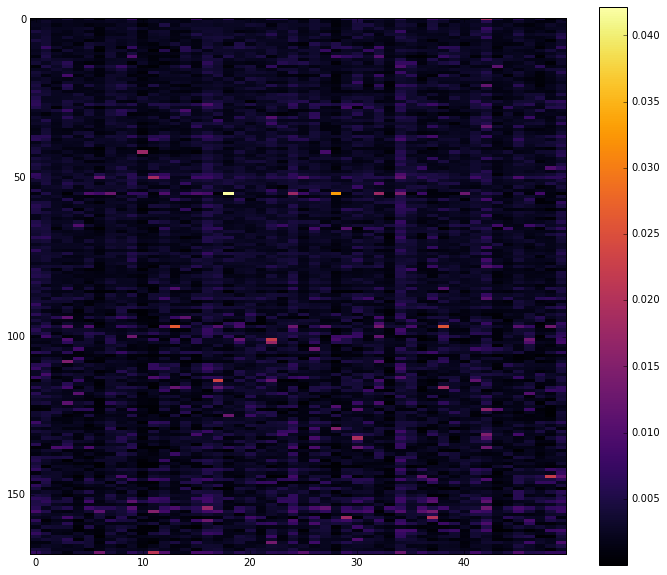

In [103]:
from __future__ import division

kegg_df = pd.DataFrame.from_csv("../data/pseudomonas_kegg_gene_matrix.csv")
names = [str(int(round(float(x[2:])) - 1)) for x in w.columns]
names[0] = "0.1"
kegg_matrix = kegg_df[names].as_matrix()
association = np.dot(kegg_matrix, np.abs(w.transpose()))
for i in range(association.shape[0]):
    association[i,:] = association[i,:] / np.sum(kegg_matrix[i,:])
df=pd.DataFrame(association)


fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)
h=ax.imshow(df, plt.get_cmap('inferno'), aspect=50/169, interpolation = "nearest")
ax.margins(0,0)
fig.colorbar(h);

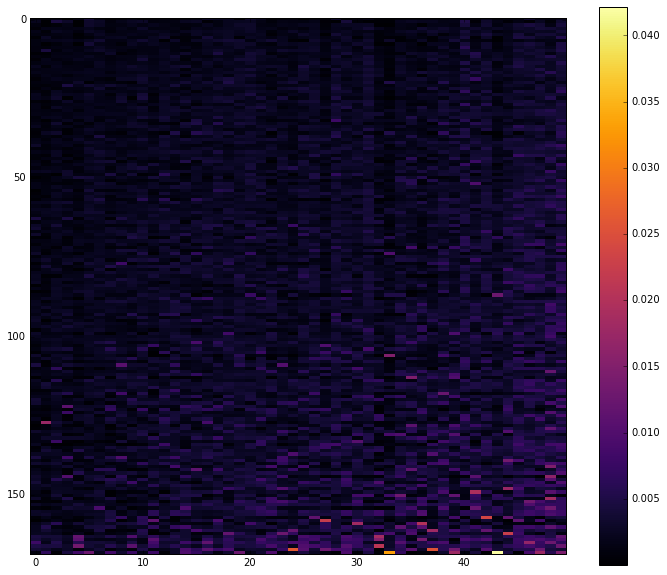

In [104]:
df = df.iloc[np.argsort((df**2).mean(axis=1)), :]
df = df.iloc[:,np.argsort((df**2).mean(axis=0))]
fig, ax = plt.subplots(1)
fig.set_size_inches(12,10)
h=ax.imshow(df, plt.get_cmap('inferno'), aspect=50/169, interpolation = "nearest")
ax.margins(0,0)
fig.colorbar(h);

In [96]:
order = association.max(axis = 0).argsort()
KEGG.iloc[abs(association).argmax(axis = 0)[order],0]

0
KEGG-Module-M00432: Leucine biosynthesis, 2-oxoisovalerate => 2-oxoisocaproate                                   5
KEGG-Module-M00200: Putative sorbitol/mannitol transport system                                                  5
KEGG-Pathway-pae00523: Polyketide sugar unit biosynthesis - Pseudomonas aeruginosa PAO1                          5
KEGG-Module-M00156: Cytochrome c oxidase, cbb3-type                                                              9
KEGG-Module-M00644: Multidrug resistance, efflux pump MexHI-OprD                                                 5
KEGG-Module-M00036: Leucine degradation, leucine => acetoacetate + acetyl-CoA                                   18
KEGG-Pathway-pae01053: Biosynthesis of siderophore group nonribosomal peptides - Pseudomonas aeruginosa PAO1     6
KEGG-Module-M00334: Type VI secretion system                                                                    45
KEGG-Module-M00157: F-type ATPase, prokaryotes and chloroplasts               

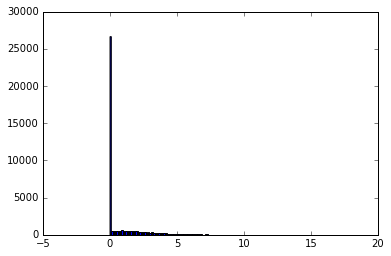

In [113]:
fig, axes = plt.subplots(1)
#axes.set_ylim([0, 15000])
plt.hist(np.array(code).flatten(), bins = 200);

In [135]:
from sklearn import linear_model

adage_w = pd.read_excel("../data/adage_weights.xls", sheetname=1, index_col = 0).transpose()

lm = linear_model.LinearRegression()
lm.fit(adage_w.transpose(), w.transpose())
lm.score(adage_w.transpose(), w.transpose())

0.79921071489369122